In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords, wordnet

import string

from tokenizers import decoders, models,normalizers,pre_tokenizers,processors,trainers,Tokenizer

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
#remove stop words
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# The Summary
**Data Analysis:** 
- read the csv file
- find null values
- remove null values
- remove duplicated values
* visualization *
- word cloud for the text
- histplot for distrupution of target values
* preprocess steps *
- remove special character
- remove emojies
- convert to lower case
- remove punctuation
- convert to word toknize
- remove stop words
- find the word steming
- finally find TFIDF vector for the words


**model development**
- we apply several machine learning algorithm using cross validation
- logistic regression with mean cross validation score= 0.7935960591133006
- Random forest with Mean cross-validation score: 0.7688013136288999
- Naive baise with Mean cross-validation score: 0.6088669950738916
- ANN with accuracy 0.7432698607444763
- Light GM classifier with Mean cross-validation score: 0.6252873563218391
- catboost regressor with Mean cross-validation score: 0.24323716285103467

**conclusion**

The developed model can help in automatically filtering and prioritizing tweets during disaster events.
By accurately identifying real disaster tweets, emergency response teams can focus on critical information and respond more effectively.
Enhanced Situational Awareness:

Real-time monitoring and analysis of social media data can provide valuable insights into the scale, location, and nature of disasters.
The model's ability to classify disaster-related tweets can contribute to a better understanding of the evolving situation on the ground.
Early Warning Systems:

By identifying early signals of disasters from social media data, authorities can initiate early warning systems and evacuation procedures, potentially saving lives and minimizing damage.
Resource Allocation Optimization:

Accurate classification of disaster-related tweets can inform resource allocation decisions, directing emergency services to areas most in need of assistance.
Public Engagement and Communication:

Effective use of social media analysis can facilitate two-way communication between authorities and the public, enabling timely dissemination of information, instructions, and safety tips during disaster events.

In [107]:
train_df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


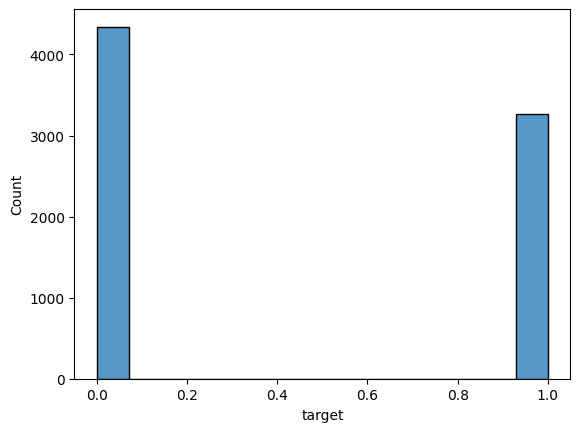

In [108]:
import seaborn as sns

sns.histplot(data=train_df, x='target')

plt.show()

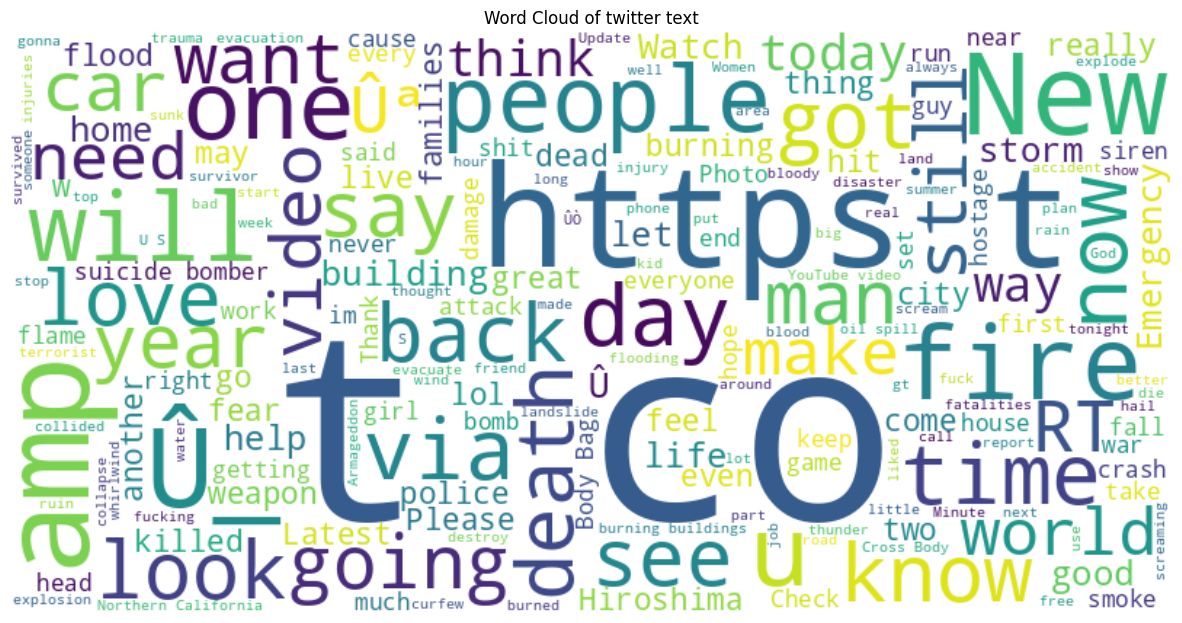

In [6]:
from wordcloud import WordCloud

text_data = ' '.join(train_df['text'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of twitter text')
plt.show()

In [109]:
#EDA
#find null values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [110]:
df=train_df.dropna()

In [111]:
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [112]:
#find duplicated values
train_df.duplicated().sum()

0

In [113]:
train_df['keyword'].unique()


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [114]:
def remove_special_characters(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters like '?', '#', '@', etc.
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# Apply the function to the 'text' column

In [115]:
#remove emojie
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [116]:
#stem word
from nltk.stem import *
ps = PorterStemmer()

def stemSentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(ps.stem(word))
    return stem_sentence

In [117]:
#apply preprocessing methods
train_df['text'] = train_df['text'].apply(remove_special_characters)
train_df['text'] = train_df['text'].apply(remove_emoji)
#convert to lower
train_df['text']= train_df['text'].str.lower()
#remove punctuation
train_df['text'] = train_df['text'].str.replace('[{}]'.format(string.punctuation), '')
#convert to word toknize
train_df['text'] = train_df['text'].apply(word_tokenize)
#remove stop words
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
#stemming words
train_df['text'] =train_df['text'].apply(lambda x: stemSentence(x))
train_df['text']


0       [deed, reason, earthquak, may, allah, forgiv, us]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, shelter, place, notifi, offic, ev...
3       [13000, peopl, receiv, wildfir, evacu, order, ...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [aria_ahrari, thetawniest, control, wild, fire...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [polic, investig, ebik, collid, car, littl, po...
7612    [latest, home, raze, northern, california, wil...
Name: text, Length: 7613, dtype: object

In [118]:
X=train_df.drop(['target','location','keyword'],axis=1)
y=train_df['target']

In [119]:
vectorize_train= train_df['text'].apply(lambda x: ' '.join(x)).values
cv = TfidfVectorizer()
X = cv.fit_transform(vectorize_train).toarray()

In [120]:
X.shape

(7613, 14934)

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [122]:
lr = LogisticRegression(dual=True,solver='liblinear',max_iter=5000)
scores = cross_val_score(lr, X_train,y_train, cv=5)
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation scores:", np.std(scores))


Cross-validation scores for each fold: [0.79474548 0.80213465 0.8045977  0.78571429 0.78078818]
Mean cross-validation score: 0.7935960591133006
Standard deviation of cross-validation scores: 0.009180729555661326


In [123]:
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[785  89]
 [228 421]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.83      0.65      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [131]:
from sklearn.model_selection import cross_val_score

random_cl = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state = 0)
scores = cross_val_score(random_cl, X_train,y_train, cv=5)
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation scores:", np.std(scores))


Cross-validation scores for each fold: [0.76765189 0.76847291 0.77011494 0.76108374 0.77668309]
Mean cross-validation score: 0.7688013136288999
Standard deviation of cross-validation scores: 0.004996756668211155


In [125]:
random_cl.fit(X_train,y_train)
predictions = random_cl.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[781  93]
 [268 381]]
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       874
           1       0.80      0.59      0.68       649

    accuracy                           0.76      1523
   macro avg       0.77      0.74      0.75      1523
weighted avg       0.77      0.76      0.76      1523



In [42]:
from sklearn.naive_bayes import GaussianNB
GN_cl = GaussianNB()
scores = cross_val_score(GN_cl,X_train,y_train, cv=5)
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation scores:", np.std(scores))

Cross-validation scores for each fold: [0.60837438 0.59688013 0.60262726 0.61986864 0.61658456]
Mean cross-validation score: 0.6088669950738916
Standard deviation of cross-validation scores: 0.008525947445482523


In [43]:
GN_cl.fit(X_train, y_train)
predictions = GN_cl.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[410 476]
 [137 500]]
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       886
           1       0.51      0.78      0.62       637

    accuracy                           0.60      1523
   macro avg       0.63      0.62      0.60      1523
weighted avg       0.65      0.60      0.59      1523



In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
# Define the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
pre = model.evaluate(X_test, y_test)


Epoch 1/100
 67/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0274

W0000 00:00:1717261016.967910     293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 0.0352

W0000 00:00:1717261018.451308     293 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9882 - loss: 0.0352 - val_accuracy: 0.7590 - val_loss: 0.8614
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9859 - loss: 0.0334 - val_accuracy: 0.7531 - val_loss: 0.9179
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0326 - val_accuracy: 0.7722 - val_loss: 0.9421
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9819 - loss: 0.0341 - val_accuracy: 0.7610 - val_loss: 0.9478
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0270 - val_accuracy: 0.7603 - val_loss: 0.9398
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0269 - val_accuracy: 0.7505 - val_loss: 0.9546
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0288 - val_accuracy: 0.7610 - val_loss: 0.9858
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9845 - loss: 0.0312 - val_accuracy: 0.7603

In [56]:
print('loss',pre[0])

loss 1.9675235748291016


In [57]:
print('accuracy',pre[1])

accuracy 0.7432698607444763


In [69]:
# Predict the labels on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=-1)  # No need to specify axis for 1D array
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))



48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[886   0]
 [637   0]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       886
           1       0.00      0.00      0.00       637

    accuracy                           0.58      1523
   macro avg       0.29      0.50      0.37      1523
weighted avg       0.34      0.58      0.43      1523



In [70]:
params = {'metrics': 'None',           
            'learning_rate': 0.1,
            'max_depth': 5,
            'num_leaves': 15,
            'colsample_bytree': 0.5,
            'min_data_in_leaf': 100,
            'reg_alpha': 0.8,
            'n_estimators': 256,
            'verbosity': -1,}

lgb_cl= lgb.LGBMClassifier(**params)

scores = cross_val_score(lgb_cl, X_train, y_train, cv=5)
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation scores:", np.std(scores))
lgb_cl.fit(X_train, y_train)
predictions = lgb_cl.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Cross-validation scores for each fold: [0.64285714 0.61576355 0.62889984 0.62151067 0.61740558]
Mean cross-validation score: 0.6252873563218391
Standard deviation of cross-validation scores: 0.00988773019200303
[[770 116]
 [390 247]]
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       886
           1       0.68      0.39      0.49       637

    accuracy                           0.67      1523
   macro avg       0.67      0.63      0.62      1523
weighted avg       0.67      0.67      0.64      1523



In [71]:
cb_cl= CatBoostRegressor(iterations=150,
                             learning_rate=0.06417237232323,
                             depth=6,                             
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 5,                                                 
                             reg_lambda=0.8519118169741291)

scores = cross_val_score(cb_cl,X_train,y_train, cv=5)
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", np.mean(scores))
print("Standard deviation of cross-validation scores:", np.std(scores))

cb_cl.fit(X_train, y_train)
final_preds = cb_cl.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0:	learn: 0.4936528	total: 91.2ms	remaining: 13.6s
5:	learn: 0.4847084	total: 241ms	remaining: 5.79s
10:	learn: 0.4785960	total: 397ms	remaining: 5.02s
15:	learn: 0.4744742	total: 556ms	remaining: 4.66s
20:	learn: 0.4703239	total: 715ms	remaining: 4.39s
25:	learn: 0.4660066	total: 877ms	remaining: 4.18s
30:	learn: 0.4627818	total: 1.04s	remaining: 3.99s
35:	learn: 0.4596251	total: 1.2s	remaining: 3.8s
40:	learn: 0.4566970	total: 1.35s	remaining: 3.6s
45:	learn: 0.4540726	total: 1.51s	remaining: 3.41s
50:	learn: 0.4514162	total: 1.66s	remaining: 3.23s
55:	learn: 0.4490142	total: 1.82s	remaining: 3.06s
60:	learn: 0.4468360	total: 1.98s	remaining: 2.88s
65:	learn: 0.4445957	total: 2.13s	remaining: 2.71s
70:	learn: 0.4426135	total: 2.28s	remaining: 2.54s
75:	learn: 0.4407085	total: 2.43s	remaining: 2.37s
80:	learn: 0.4388992	total: 2.58s	remaining: 2.2s
85:	learn: 0.4368819	total: 2.74s	remaining: 2.04s
90:	learn: 0.4352245	total: 2.89s	remaining: 1.87s
95:	learn: 0.4336430	total: 3.05s	re

In [ ]:
#the best model is logistic regression with F1score 79%